In [65]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import decomposition
import gym

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [66]:
# envname = "HalfCheetah"
envname = "Hopper"
# envname = "Walker2d"
pos_data = np.load("./data/stochastic.trpo."+envname+".0.00.npz")
n_pos_demos = 10
pos_obs = np.concatenate([pos_data['obs'][idx][:-1] for idx in range(n_pos_demos)])
pos_next_obs = np.concatenate([pos_data['obs'][idx][1:] for idx in range(n_pos_demos)])
pos_act = np.concatenate([pos_data['acs'][idx][:-1] for idx in range(n_pos_demos)])
pos_exp_rets = np.mean([pos_data['ep_rets'][idx] for idx in range(n_pos_demos)])

print("{:d} positive demonstrations are loaded".format(pos_data['obs'].shape[0]))
print("Expert's average return : {:.03f}".format(pos_exp_rets))
print("Use {:d} positive demos".format(n_pos_demos))
print("Observation shape : {}".format(pos_obs.shape))
print("Action shape : {}".format(pos_act.shape))
print("Next observation shape : {}".format(pos_next_obs.shape))
print("")

demo_file = open('./'+envname+'-v1-negative-demo.pkl', 'rb')
neg_data = pickle.load(demo_file)[0]
n_neg_demos = 100
neg_obs = np.concatenate([neg_data[idx]['observes'][:-1] for idx in range(n_neg_demos)])
neg_next_obs = np.concatenate([neg_data[idx]['observes'][1:] for idx in range(n_neg_demos)])
neg_act = np.concatenate([neg_data[idx]['actions'][:-1] for idx in range(n_neg_demos)])

print("{:d} negative demonstrations are loaded".format(len(neg_data)))
print("Use {:d} negative demos".format(n_neg_demos))
print("Observation shape : {}".format(neg_obs.shape))
print("Action shape : {}".format(neg_act.shape))
print("Next observation shape : {}".format(neg_next_obs.shape))
print("")

obs = np.concatenate([pos_obs,neg_obs])
next_obs = np.concatenate([pos_next_obs,neg_next_obs])
act = np.concatenate([pos_act,neg_act])

env = gym.make(envname+"-v1")
env.seed(seed=0)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

obs_mean = np.mean(obs,axis=0)
obs_std = np.std(obs,axis=0)
next_obs_mean = np.mean(next_obs,axis=0)
next_obs_std = np.mean(next_obs,axis=0)
act_max = np.max(np.abs(act),axis=0)

nz_obs = (obs - obs_mean)/obs_std
nz_next_obs = (next_obs - next_obs_mean)/next_obs_std
nz_act = act/act_max

nz_pos_obs = (pos_obs - obs_mean)/obs_std
nz_pos_next_obs = (pos_next_obs - next_obs_mean)/next_obs_std
nz_pos_act = pos_act/act_max

nz_neg_obs = (neg_obs - obs_mean)/obs_std
nz_neg_next_obs = (neg_next_obs - next_obs_mean)/next_obs_std
nz_neg_act = neg_act/act_max


[2018-07-12 20:35:28,122] Making new env: Hopper-v1


1500 positive demonstrations are loaded
Expert's average return : 2249.524
Use 10 positive demos
Observation shape : (5926, 11)
Action shape : (5926, 3)
Next observation shape : (5926, 11)

1000 negative demonstrations are loaded
Use 100 negative demos
Observation shape : (897, 11)
Action shape : (897, 3)
Next observation shape : (897, 11)



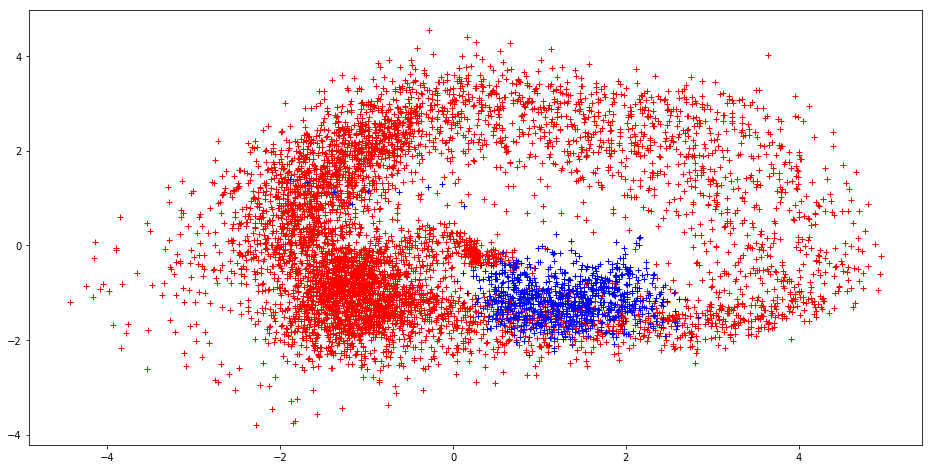

In [68]:
pca = decomposition.PCA(n_components=2)
pca.fit(nz_obs)
pos_demo_pca = pca.transform(nz_pos_obs)
neg_demo_pca = pca.transform(nz_neg_obs)

fig = plt.figure(figsize=(16, 8))
plt.plot(pos_demo_pca[:,0],pos_demo_pca[:,1],'r+')
plt.plot(neg_demo_pca[:,0],neg_demo_pca[:,1],'b+')
plt.show()

# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(90, 60)
# plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],observes_demo_pca[:,2],marker='+',c='b')
# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(30, 30)
# plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],observes_demo_pca[:,2],marker='+',c='b')
# plt.show()

In [69]:
class LatentDynamics():
    def __init__(self, act_dim, hdim = 16, ldim = 4, max_std = 1e-1, epochs = 10000, lr = 1e-5):
        self.act_dim = act_dim
        
        self.seed = 0
        self.epochs = epochs
        
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self.std = max_std
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._ldm_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.next_latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'next_latent')
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _ldm_nn(self):
        self.passive_dynamics, self.control_dynamics, self.control_std = self._dynamics(self.latent_ph)
        self.next_latent_predict = self.latent_ph + self.passive_dynamics + tf.reduce_sum(self.control_dynamics*tf.tile(self.act_ph[:,tf.newaxis,:],[1,self.ldim,1]))
        self.next_latent = self.next_latent_predict + self.control_std*tf.random_normal(tf.shape(self.next_latent_predict))
        
    def _dynamics(self,latent,reuse=False):
        hid1_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("control_dynamics"):
            # Control Dynamics
            out = tf.layers.dense(latent, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
#             out = tf.layers.dense(out, hid1_size, tf.tanh,
#                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h3",
#                                   reuse=reuse)
#             out = tf.layers.dense(out, hid1_size, tf.tanh,
#                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h4",
#                                   reuse=reuse)
            passive_dynamics = tf.layers.dense(out, latent_size,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="passive_dynamics",
                                  reuse=reuse)
            control_std_logits = tf.layers.dense(out, latent_size,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="std_dynamics",
                                  reuse=reuse)
            control_std = self.std*tf.sigmoid(control_std_logits) + 1e-6
            control_dynamics_flatten = tf.layers.dense(out, latent_size*self.act_dim,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="flatten_dynamics",
                                  reuse=reuse)
            control_dynamics = tf.reshape(control_dynamics_flatten,[-1,latent_size,self.act_dim], name="control_dynamics")
            
        return passive_dynamics, control_dynamics, control_std

            
    def _loss_train_op(self):
        # Define Loss
        latent_prediction_loss = tf.reduce_sum(tf.log(self.control_std) + 0.5*tf.square((self.next_latent_predict - self.next_latent_ph)/self.control_std),axis=1)
        self.dyn_loss = tf.reduce_mean(latent_prediction_loss)
        
        l2loss = 0.5*tf.reduce_sum(tf.square(self.next_latent_predict - self.next_latent_ph),axis=1)
        self.l2loss = tf.reduce_mean(l2loss)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.dyn_loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
   
    def get_prediction(self,latent):
        next_latent = self.sess.run(self.next_latent,feed_dict={self.latent_ph:latent})
        return next_latent
    
    def get_control_dynamics(self,latent):
        return self.sess.run(self.control_dynamics,feed_dict={self.latent_ph:latent})
            
    def train(self,latent,act,next_latent,batch_size = 1024): # TRAIN POLICY
        
        num_batches = max(latent.shape[0] // batch_size, 1)
        batch_size = latent.shape[0] // num_batches
        
        for e in range(self.epochs+1):
            latent,act,next_latent = shuffle(latent,act,next_latent,random_state=0)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.latent_ph: latent[start:end,:],
                     self.act_ph: act[start:end,:],
                     self.next_latent_ph: next_latent[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if e < self.epochs/3:
                self.lr = 1e-4
            elif e < 2*self.epochs/3:
                self.lr = 5e-5
            else:
                self.lr = 1e-5
                
            if (e%500)==0:
                feed_dict = {self.latent_ph: latent,
                     self.act_ph: act,
                     self.next_latent_ph: next_latent,
                     self.lr_ph: self.lr}        
                dyn_loss, l2loss = self.sess.run([self.dyn_loss, self.l2loss], feed_dict)
                print('[{:05d}/{:05d}] Latent Prediction : {:.05f}, L2 Loss : {:.05f}'.
                      format(e, self.epochs, dyn_loss, l2loss))
        return dyn_loss

In [70]:
ldm = LatentDynamics(act_dim,hdim=128,ldim=obs_dim)
ldm.epochs = 30000
ldm.train(nz_obs,nz_act,nz_next_obs)

[00000/30000] Latent Prediction : 47960792.00000, L2 Loss : 119943.56250
[00500/30000] Latent Prediction : 13264015.00000, L2 Loss : 132013.76562
[01000/30000] Latent Prediction : 16172343.00000, L2 Loss : 161163.87500
[01500/30000] Latent Prediction : 13152121.00000, L2 Loss : 131210.48438
[02000/30000] Latent Prediction : 8189300.50000, L2 Loss : 81490.43750
[02500/30000] Latent Prediction : 7760777.50000, L2 Loss : 77352.92188
[03000/30000] Latent Prediction : 6096344.00000, L2 Loss : 60791.58984
[03500/30000] Latent Prediction : 4668079.00000, L2 Loss : 46566.00391
[04000/30000] Latent Prediction : 4038195.00000, L2 Loss : 40261.14062
[04500/30000] Latent Prediction : 3656852.75000, L2 Loss : 36466.31641
[05000/30000] Latent Prediction : 2828394.00000, L2 Loss : 28195.98242
[05500/30000] Latent Prediction : 2354538.75000, L2 Loss : 23498.58789
[06000/30000] Latent Prediction : 1926117.62500, L2 Loss : 19180.89453
[06500/30000] Latent Prediction : 2232505.50000, L2 Loss : 22190.8535

125103.46

In [71]:
class Value(object):
    def __init__(self, obs_dim, act_dim, hdim = 16, ldim = 4, epochs = 10000, lr = 1e-3):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.seed = 0
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self.variables = tf.global_variables()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.pos_latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'pos_latent')
        self.pos_control_dynamics_ph = tf.placeholder(tf.float32, (None, self.ldim, self.act_dim), 'pos_control_dynamics')
        self.pos_control_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'pos_control')
        self.neg_latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'neg_latent')
        self.neg_control_dynamics_ph = tf.placeholder(tf.float32, (None, self.ldim, self.act_dim), 'neg_control_dynamics')
        self.neg_control_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'neg_control')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _policy_nn(self):
        self.pos_value  = self._value_nn(self.pos_latent_ph)
        value_gradients = tf.gradients(self.pos_value,self.pos_latent_ph,name="pos_value_grads")[0]
        self.pos_control = - tf.reduce_sum(tf.tile(value_gradients[:,:,tf.newaxis],[1,1,self.act_dim])*self.pos_control_dynamics_ph,axis=1)
        
        self.neg_value = self._value_nn(self.neg_latent_ph, reuse=True)
        value_gradients = tf.gradients(self.neg_value,self.neg_latent_ph,name="neg_value_grads")[0]
        self.neg_control = - tf.reduce_sum(tf.tile(value_gradients[:,:,tf.newaxis],[1,1,self.act_dim])*self.neg_control_dynamics_ph,axis=1)
        
    def _value_nn(self, latent_ph, reuse=False):
        hid1_size = self.hdim
        hid2_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("value_network"):
            # Encoder
            out = tf.layers.dense(latent_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid2_size, tf.cosh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
#             out = tf.layers.dense(out, hid2_size, tf.nn.relu,
#                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h3",
#                                   reuse=reuse)
#             out = tf.layers.dense(out, hid2_size, tf.nn.relu,
#                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h4",
#                                   reuse=reuse)
#             out = tf.layers.dense(out, hid2_size, tf.nn.relu,
#                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h5",
#                                   reuse=reuse)
            value = tf.layers.dense(out, 1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed),
                                    name="value",
                                    reuse=reuse)
        return value

    def _loss_train_op(self):
        pos_loss = tf.reduce_sum(tf.square(self.pos_control_ph - self.pos_control))
        self.pos_loss = tf.reduce_mean(pos_loss)
        
        neg_loss = tf.reduce_sum(tf.maximum(1e-1-tf.square(self.neg_control_ph - self.neg_control),0))
        self.neg_loss = tf.reduce_mean(neg_loss)
        
#         weight_decay = tf.reduce_sum([tf.reduce_sum(tf.reduce_sum(tf.square(var))) for var in self.variables])
        reg = tf.reduce_mean(tf.square(self.pos_value)) + tf.reduce_mean(tf.square(self.neg_value))
        
        self.loss = self.pos_loss + self.neg_loss + 1e-3*reg #+ 1e-4*weight_decay #+ self.neg_loss
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
    
    def get_control(self,latent,control_dynamics):
        ctrl, val = self.sess.run([self.pos_control, self.pos_value],feed_dict={self.pos_latent_ph:latent,self.pos_control_dynamics_ph:control_dynamics})
        return ctrl, val
    
    def train(self,pos_latent,pos_control_dynamics,pos_control,neg_latent,neg_control_dynamics,neg_control,batch_size = 1024): # TRAIN POLICY
        
        pos_num_batches = max(pos_latent.shape[0] // batch_size, 1)
        neg_num_batches = max(neg_latent.shape[0] // batch_size, 1)
        pos_batch_size = pos_latent.shape[0] // pos_num_batches
        neg_batch_size = neg_latent.shape[0] // neg_num_batches
        num_batches = min(pos_num_batches,neg_num_batches)
        for e in range(self.epochs+1):
            pos_latent,pos_control_dynamics,pos_control= shuffle(pos_latent,pos_control_dynamics,pos_control,random_state=0)
            neg_latent,neg_control_dynamics,neg_control= shuffle(neg_latent,neg_control_dynamics,neg_control,random_state=0)
            for j in range(num_batches):
                pos_start = j * pos_batch_size
                pos_end = (j + 1) * pos_batch_size
                neg_start = j * neg_batch_size
                neg_end = (j + 1) * neg_batch_size
                feed_dict = {self.pos_latent_ph: pos_latent[pos_start:pos_end,:],
                     self.pos_control_dynamics_ph: pos_control_dynamics[pos_start:pos_end,:,:],
                     self.pos_control_ph: pos_control[pos_start:pos_end,:],
                     self.neg_latent_ph: neg_latent[neg_start:neg_end,:],
                     self.neg_control_dynamics_ph: neg_control_dynamics[neg_start:neg_end,:,:],
                     self.neg_control_ph: neg_control[neg_start:neg_end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if e < self.epochs/3:
                self.lr = 1e-3
            elif e < 2*self.epochs/3:
                self.lr = 5e-4
            else:
                self.lr = 1e-4
                
            if (e%500)==0:
                feed_dict = {self.pos_latent_ph: pos_latent,
                     self.pos_control_dynamics_ph: pos_control_dynamics,
                     self.pos_control_ph: pos_control,
                     self.neg_latent_ph: neg_latent,
                     self.neg_control_dynamics_ph: neg_control_dynamics,
                     self.neg_control_ph: neg_control,
                     self.lr_ph: self.lr}        
                loss, pos_loss, neg_loss = self.sess.run([self.loss, self.pos_loss, self.neg_loss], feed_dict)
                print('[{}/{}] Loss : {:.06f}, Pos : {:.06f}, Neg : {:.06f}'.
                      format(e, self.epochs, loss, pos_loss, neg_loss))
        return loss

In [72]:
value = Value(obs_dim,act_dim,hdim=128,ldim=obs_dim)

pos_control_dynamics = ldm.get_control_dynamics(nz_pos_obs)
neg_control_dynamics = ldm.get_control_dynamics(nz_neg_obs)

value.epochs = 30000
value.train(nz_pos_obs,pos_control_dynamics,nz_pos_act,nz_neg_obs,neg_control_dynamics,nz_neg_act)

[0/30000] Loss : 1411.113892, Pos : 1159.734985, Neg : 251.378937
[500/30000] Loss : 651.844604, Pos : 648.230835, Neg : 3.452967
[1000/30000] Loss : 511.797485, Pos : 509.143036, Neg : 2.467700
[1500/30000] Loss : 463.461517, Pos : 461.169617, Neg : 2.139347
[2000/30000] Loss : 440.294983, Pos : 438.818665, Neg : 1.343269
[2500/30000] Loss : 420.914246, Pos : 419.753052, Neg : 1.037075
[3000/30000] Loss : 409.722656, Pos : 408.794373, Neg : 0.821550
[3500/30000] Loss : 402.500610, Pos : 401.318970, Neg : 1.093442
[4000/30000] Loss : 393.274017, Pos : 392.379333, Neg : 0.814736
[4500/30000] Loss : 387.605011, Pos : 386.372711, Neg : 1.170195
[5000/30000] Loss : 380.565826, Pos : 379.368408, Neg : 1.147283
[5500/30000] Loss : 378.866943, Pos : 378.149841, Neg : 0.670696
[6000/30000] Loss : 373.088562, Pos : 371.941101, Neg : 1.107074
[6500/30000] Loss : 368.026184, Pos : 367.062988, Neg : 0.923250
[7000/30000] Loss : 363.652618, Pos : 362.815857, Neg : 0.797439
[7500/30000] Loss : 361.6

293.33517

3582.1846874970506


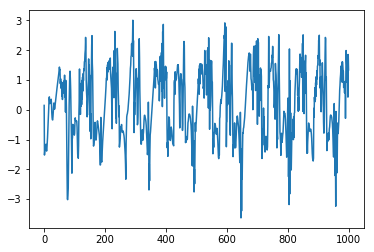

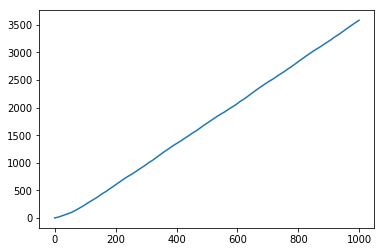

In [80]:
observation = env.reset()
rewards = []
vals = []
frames = []
done = False
while not done:
# for t in range(1000):    
    nz_observation = (observation - obs_mean)/obs_std
    control_dynamic = ldm.get_control_dynamics([nz_observation])
    nz_action, val = value.get_control([nz_observation],control_dynamic)
#     nz_action = np.clip(nz_action,-1,1)
    action = nz_action*act_max
    
    observation, reward, done, info = env.step(action)
    frames.append(env.render("rgb_array"))
    observation = np.squeeze(observation)
    rewards.append(reward)
    vals.append(-val[0][0])

print(np.sum(rewards))
plt.figure()
plt.plot(vals)
plt.figure()
plt.plot(np.cumsum(rewards))
plt.show()

In [26]:
import skvideo.io
outputdata = np.asarray(frames).astype(np.uint8)
skvideo.io.vwrite(envname+"-ioc_pos.mp4", outputdata)

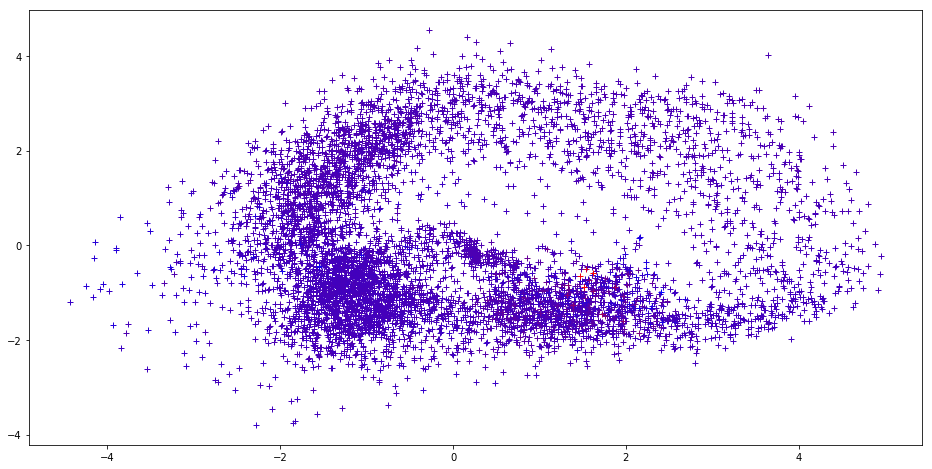

In [81]:
pca = decomposition.PCA(n_components=2)
pca.fit(nz_obs)

control_dynamic = ldm.get_control_dynamics(nz_obs)
_, observes_value = value.get_control(nz_obs,control_dynamic)
range_value = np.max(observes_value) - np.min(observes_value)

observes_demo_pca = pca.transform(nz_obs)

fig = plt.figure(figsize=(16, 8))
r = [1,0,0]
b = [0,0,1]
for i in range(len(observes_value)):
    ratio = (observes_value[i] - np.min(observes_value))/range_value
    c = r*ratio + b*(1-ratio)
    plt.plot(observes_demo_pca[i,0],observes_demo_pca[i,1],'+',color=c)

plt.show()

# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(90, 60)
# plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],observes_demo_pca[:,2],marker='+',c='b')
# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(30, 30)
# plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],observes_demo_pca[:,2],marker='+',c='b')
# plt.show()